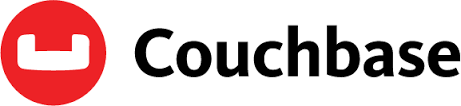

In [33]:
Image("images/_cb.png")

# An introduction to the Couchbase sub-document API in Python

***Download this notebook (to execute the code for yourself!) here:***
https://github.com/SimonLeigh/JupyterNotebooks/blob/master/Couchbase%20Sub-Document%20Examples.ipynb

In this notebook I will explore the usage of the Couchbase Key/Value and sub-document APIs in the Python SDK 2.x in order to highlight the similarities and differences between them.

The sub-document API was introduced in Couchbase Server version 4.5. The feature provides a means to send to or request from the Server only **portions** of a full document. 

This trades the cost of parsing the document on the server side for the benefit of reduced network traffic when reading (or adding) only small amounts of data relative to the total size of the document.

It also allows one to write data into a document without the necessity of reading the document first. Consider operations such as: array prepend/append, array index retrieval, field addition, etc.

My colleague David Maier provides more context and background in his blog post below, and there is also complete documentation available at Couchbase.com.

David's blog: http://blog.couchbase.com/2016/may/couchbase-server-45s-new-sub-document

Couchbase Python Library API docs: http://pythonhosted.org/couchbase/index.html

Download Couchbase: http://www.couchbase.com/nosql-databases/downloads


### First we set up our configuration

***Please note that you must first install Couchbase Server 4.5 and configure the sample bucket `travel-sample` in order to use the following code interactively. ***

http://developer.couchbase.com/documentation/server/current/settings/install-sample-buckets.html

In [34]:
COUCHBASE_SERVER = "localhost"
COUCHBASE_BUCKET = "travel-sample"

import uuid
from IPython.display import display_javascript, display_html, display, Image
from IPython.core.display import HTML
import json

### Next, we import necessary Couchbase libraries

In [35]:
from couchbase.bucket import Bucket
import couchbase.subdocument as SD
from couchbase import exceptions

### Connect to Couchbase

In [36]:
try:
    bucket = Bucket("couchbase://{0}/{1}".format(COUCHBASE_SERVER,COUCHBASE_BUCKET))
except exceptions.CouchbaseError as err:
    print("Couchbase error: {0}".format(err))
else:
    print("Successfully connected to Couchbase!")

Successfully connected to Couchbase!


### Retrieve one WHOLE document, by key, from the bucket

In [37]:
keyToRetrieve="airport_1284"
try:
    completeDocument = bucket.get(keyToRetrieve)
except Exception as err:
    if isinstance(err, exceptions.NotFoundError):
        print("Document %s not found in bucket: {0}".format(err.key, COUCHBASE_BUCKET))
except:
    print("Unhandled Exception encountered: {0}".format(err))

### Let's look at the return type of the get operation

In [38]:
print type(completeDocument)

<type 'ValueResult'>


Note that the returned **ValueResult** object from a get command contains also Couchbase Metadata.

### And what it is composed of...

In [39]:
print completeDocument

ValueResult<rc=0x0, key=u'airport_1284', value={u'city': u'Albi', u'tz': u'Europe/Paris', u'country': u'France', u'icao': u'LFCI', u'geo': {u'lat': 43.913887, u'alt': 564.0, u'lon': 2.113056}, u'faa': u'LBI', u'type': u'airport', u'id': 1284, u'airportname': u'Le Sequestre'}, cas=0xfc3052430100, flags=0x2000006>


We want only the **value** property to  get the true document body from Couchbase Server.

### Let's have a look at the document body

In [40]:
print completeDocument.value

{u'city': u'Albi', u'tz': u'Europe/Paris', u'country': u'France', u'icao': u'LFCI', u'geo': {u'lat': 43.913887, u'alt': 564.0, u'lon': 2.113056}, u'faa': u'LBI', u'type': u'airport', u'id': 1284, u'airportname': u'Le Sequestre'}


### So, now that we have seen what the API is like for a full document read, let's look at the sub-document API

In [41]:
# This field actually exists within the document we will retrieve.
fieldToRetrieve="geo"
# This field DOES NOT EXIST within the document we will retrieve.
missingFieldToRetrieve="foobar"
try:
    # We can use the lookup_in method of a bucket object to retrieve sub-document fragments.
    subDocument = bucket.lookup_in(keyToRetrieve, SD.get(fieldToRetrieve))
    subDocumentNoField = bucket.lookup_in(keyToRetrieve, SD.get(missingFieldToRetrieve))
except Exception as err:
    if isinstance(err, exceptions.NotFoundError):
        print("Document {0} not found in bucket: {0}".format(err.key, COUCHBASE_BUCKET))
except:
    print("Unhandled Exception encountered: {0}".format(err))
else:
    print("Success ")

Success 


It is worth nothing here that there is no Error/Exception that occurs if we request a sub-document lookup from a document associated with a Key that **DOES** exist within the database. Even if the **FIELD** we are seeking **DOES NOT** exist within the document itself. We have to handle the fact that even though we get a result to the operation from the Server that it may not contain the data we expected.

### Let's look at the return type of the subDocument operation

In [42]:
print type(subDocument)
print type(subDocumentNoField)

<class 'couchbase.result.SubdocResult'>
<class 'couchbase.result.SubdocResult'>


### ... and what the returned value of the subDocument operations is composed of

In [43]:
print subDocument
print subDocumentNoField

SubdocResult<rc=0x0, key='airport_1284', cas=0xfc3052430100, specs=(Spec<GET, 'geo'>,), results=[(0, {u'lat': 43.913887, u'alt': 564.0, u'lon': 2.113056})]>
SubdocResult<rc=0x49[Could not execute one or more multi lookups or mutations], key='airport_1284', cas=0x0, specs=(Spec<GET, 'foobar'>,), results=[(63, None)]>


### We can access the subDocument using the get() method, iteration, or direct index access

Notice that the returned value from the get() operation is a tuple with the error code (0 if no error) and the JSON fragment wheras the other access methods simply return the value.

#### get()

In [44]:
print "Field with name {0} exists? {1}".format(fieldToRetrieve,
                                               subDocument.exists(fieldToRetrieve))

print "Content of SubdocResult is: {0}".format(subDocument.get(fieldToRetrieve))

print "Field with name {0} exists? {1}".format(missingFieldToRetrieve, 
                                               subDocumentNoField.exists(missingFieldToRetrieve))

print "Content of SubdocResult is: {0}".format(subDocumentNoField.get(missingFieldToRetrieve))

Field with name geo exists? True
Content of SubdocResult is: (0, {u'lat': 43.913887, u'alt': 564.0, u'lon': 2.113056})
Field with name foobar exists? False
Content of SubdocResult is: (63, None)


#### Iteration

In [45]:
for value in subDocument:
    print value

{u'lat': 43.913887, u'alt': 564.0, u'lon': 2.113056}


#### Index access

In [46]:
print subDocument[0]

{u'lat': 43.913887, u'alt': 564.0, u'lon': 2.113056}


### Finally, let's take a look at the complete document and our sub-document fragment.

In [47]:
print(json.dumps(completeDocument.value, indent=2))

{
  "city": "Albi", 
  "tz": "Europe/Paris", 
  "country": "France", 
  "icao": "LFCI", 
  "geo": {
    "lat": 43.913887, 
    "alt": 564.0, 
    "lon": 2.113056
  }, 
  "faa": "LBI", 
  "type": "airport", 
  "id": 1284, 
  "airportname": "Le Sequestre"
}


In [48]:
print(json.dumps(subDocument.get("geo")[1], indent=2))

{
  "lat": 43.913887, 
  "alt": 564.0, 
  "lon": 2.113056
}


### Summary

So, we have seen a simple introduction to the sub-document API in Couchbase 4.5 using the Python SDK.

In the next notebook I will illustrate the use of the mutate_in commands as well as extend the example to retrieving and mutating multiple fields in a document simultaneously. We will also discuss using embedded atomic counters within documents to manage references.

@simonleigh0x01 

simon.leigh ...at... couchbase.com